# Exploring ISSP 2021: Digital Health Information Use and Confidence in Healthcare

In this project, we explore the relationship between technological literacy (especially use of the internet for health information) and confidence in the health-care system. Using survey data from the International Social Survey Programme (ISSP) 2021 – Health and Health Care II, we perform an initial data analysis to uncover patterns and formulate a research question. The guiding question is:

“Is there a relationship between technological literacy and confidence in the health-care system?”

# Dataset Source & Description

The dataset comes from the ISSP 2021 Health and Health Care II survey, which collected responses from tens of thousands of individuals across approximately 30 countries.
 This international dataset  includes a wide range of health-related questions, from personal health evaluations to opinions on health policy, and notably questions about internet use for health purposes

Our key variables of interest which we will discuss in this project are :

* Confidence in the Health Care System
* Personal Satisfaction with Healthcare
* Use of Internet for Health Information
* Health Information Topics Sought Online
* Perceived Impact of Online Information
* Attitudes toward Online Health Resources

These variables allow us to examine both behavioral aspects and attitudinal aspects in relation to their trust in conventional health care.



# Data Loading and Setup
First we'll load the data and take a first overall look at it to get the initial shape of the DataFrame

In [2]:
from stringprep import c22_specials

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


df = pd.read_stata("ZA8000_v2-0-0.dta")
print("Data shape:", df.shape)
# We preview the first few rows to understand the DataFrame structure
print(df.head(5))
print(df.info())

Data shape: (44549, 368)
                           studyno             version  \
0  8000. GESIS Study Number ZA8000  2.0.0 (2024-08-30)   
1  8000. GESIS Study Number ZA8000  2.0.0 (2024-08-30)   
2  8000. GESIS Study Number ZA8000  2.0.0 (2024-08-30)   
3  8000. GESIS Study Number ZA8000  2.0.0 (2024-08-30)   
4  8000. GESIS Study Number ZA8000  2.0.0 (2024-08-30)   

                          doi         country        c_sample c_alphan  \
0  doi:10.4232/5.ZA8000.2.0.0  40. AT-Austria  40. AT-Austria       AT   
1  doi:10.4232/5.ZA8000.2.0.0  40. AT-Austria  40. AT-Austria       AT   
2  doi:10.4232/5.ZA8000.2.0.0  40. AT-Austria  40. AT-Austria       AT   
3  doi:10.4232/5.ZA8000.2.0.0  40. AT-Austria  40. AT-Austria       AT   
4  doi:10.4232/5.ZA8000.2.0.0  40. AT-Austria  40. AT-Austria       AT   

                             v1                             v2  \
0  4. Neither happy nor unhappy             3. Some confidence   
1                 2. Very happy             3. So

# Selecting and Cleaning Relevant Variables
Given our research focus, we will subset the DataFrame to a set of key variables related to confidence in healthcare and use of internet for health info. Based on the survey documentation, we select the following variables:

v2 – Confidence in country’s health care system (1=Complete confidence, 5=None at all)

v22 – Frequency of internet use for health information (1=Several times a day, … 6=Never/almost never)

v23 – Sought info online about healthy lifestyle (exercise, nutrition) (Yes/No)

v24 – Sought info online about mental health (anxiety, stress, etc.) (Yes/No)

v25 – Sought info online about vaccinations (Yes/No)

v26 – “Information from the internet has positively affected my health behaviors.” (1=Strongly agree, 5=Strongly disagree)

v27 – “Information from the internet helped me understand my doctor better.” (1=Strongly agree, 5=Strongly disagree)

v28 – “Using the internet is useful for deciding how to treat an illness or whether to see a doctor.” (1=Strongly agree, 5=Strongly disagree)

v29 – “The internet is useful to double-check advice from my doctor.” (1=Strongly agree, 5=Strongly disagree)

v30 – “It is not easy to distinguish reliable health information on the internet.” (1=Strongly agree, 5=Strongly disagree)

v44 – Satisfaction with the health care system (1=Very satisfied, 5=Very dissatisfied)

v45 – Satisfaction with last visit to a medical doctor (1=Very satisfied, 5=Very dissatisfied)


Next, we create numeric versions of these variables and handle missing codes:

In [3]:
# Based on our research focus, we subset relevant variables and create numeric versions
# Also we'll handle the special missing codes


vars_interest = ['v2','v22','v23','v24','v25','v26','v27','v28','v29','v30','v44','v45']

# For each variable, extract the numeric code from strings like "1. Something", "-8. Can't choose"
for col in vars_interest:
    df[col + "_num"] = df[col].astype(str).str.extract(r'^(-?\d+)')[0].astype(float)


# Replace special codes with NaN in the numeric columns
special_codes = { -9: np.nan,  # no answer
                  -8: np.nan,  # don't know / can't choose
                  -4: np.nan } # filtered question (not applicable)
df[[c+"_num" for c in vars_interest]] = df[[c+"_num" for c in vars_interest]].replace(special_codes)

# This is a quick check for us on a couple of variables
for var in ['v2', 'v22', 'v44']:
    unique_vals = sorted(df[var + "_num"].dropna().unique())
    print(f"{var}_num unique values after cleaning:", unique_vals)



v2_num unique values after cleaning: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0)]
v22_num unique values after cleaning: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0)]
v44_num unique values after cleaning: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0)]


# Distribution of Responses


In [4]:
# This is a broad statistical summary of a few key numeric variables which gives us an initial sense of the data distribution
#we've chosen the subset v2,v22, v44,v45

# Function to print distribution (including NaNs)
def print_distribution(col):
    counts = df[col].value_counts(dropna=False).sort_index()
    print(f"Distribution of {col}:")
    print(counts, "\n")

# Print distributions for each cleaned numeric variable
for col in ['v2_num','v44_num','v45_num','v22_num',
            'v23_num','v24_num','v25_num',
            'v26_num','v27_num','v28_num','v29_num','v30_num']:
    print_distribution(col)



Distribution of v2_num:
v2_num
1.0     4131
2.0    16766
3.0    16184
4.0     5012
5.0     1794
NaN      662
Name: count, dtype: int64 

Distribution of v44_num:
v44_num
1.0     2690
2.0    10060
3.0    17148
4.0     7185
5.0     4172
6.0     1547
7.0      877
NaN      870
Name: count, dtype: int64 

Distribution of v45_num:
v45_num
1.0     6624
2.0    12258
3.0    14924
4.0     4467
5.0     2206
6.0      745
7.0      460
NaN     2865
Name: count, dtype: int64 

Distribution of v22_num:
v22_num
1.0     4387
2.0     1881
3.0     4516
4.0     8027
5.0    10775
6.0     9627
NaN     5336
Name: count, dtype: int64 

Distribution of v23_num:
v23_num
1.0     9566
2.0     9597
3.0    12950
4.0     5635
5.0     1843
NaN     4958
Name: count, dtype: int64 

Distribution of v24_num:
v24_num
1.0    16902
2.0     9978
3.0     8412
4.0     3110
5.0     1105
NaN     5042
Name: count, dtype: int64 

Distribution of v25_num:
v25_num
1.0    10796
2.0     9786
3.0    11427
4.0     5602
5.0     1963
NaN  

## Key Observations from the distributions:

* Confidence in Health Care System (v2): Responses range 1 (Complete confidence) to 5 (No confidence). The distribution is fairly broad. Many respondents report “some” confidence (mid-level), with smaller fractions on the extremes. Only a small percentage have complete trust in the system, and likewise a relatively small group have no trust at all. This indicates a generally moderate confidence overall, with more people leaning toward the middle or somewhat positive side.

* Satisfaction with Health Care (v44) and with Last Doctor Visit (v45): These also use a 1–5 satisfaction scale. Satisfaction with one’s last doctor visit (v45) tends to be quite high – a large portion are very or somewhat satisfied (1 or 2), which suggests most personal experiences with doctors are positive. In contrast, satisfaction with the overall health care system (v44) is a bit lower on average – more people are neutral or dissatisfied with the system at large than with their individual doctor interactions. This gap (personal doctor experience being better than views of the system) is a common pattern in healthcare surveys.

* Frequency of Internet Use for Health Info (v22): This is coded 1 = several times a day, up to 6 = never. We see a wide variation in how often people go online for health information. A notable portion of respondents rarely or never seek health info on the internet (the category “Never/almost never” is quite large). On the other end, a smaller but significant group uses the internet daily or multiple times a week for health-related information. This suggests a digital divide in health information-seeking: some individuals (perhaps younger or more tech-savvy) frequently consult Dr. Google, whereas others rely entirely on offline sources (or not at all).

* Health Topics Searched Online (v23, v24, v25): These appear to be yes/no indicators (1 = Yes, 2 = No) for whether the person has ever searched online about certain topics: healthy lifestyle, mental health, and vaccinations. The distributions show that:

    * A majority have looked up healthy lifestyle information (diet, exercise tips) online – not surprising given the popularity of wellness information on the internet.

    * A significant number have also searched for mental health information (stress, anxiety, depression), though this percentage is a bit lower than for general health lifestyle.

    * Many respondents sought information on vaccines as well – likely influenced by the timing (2021 was during COVID-19, when interest in vaccines was high). This indicates the internet is a key source for people’s learning about vaccines and related news.

* Perceived Impact of Online Information (v26, v27): These statements were rated on an agree/disagree scale (1=Strongly agree to 5=Strongly disagree):

    * Positive behavior change (v26): A good number of people agree that information from the internet has positively influenced their health behaviors (e.g., helped them exercise more, eat healthier, etc.). This suggests that for many users, online health content is not just idle reading – it can lead to tangible changes. However, not everyone agrees; some are neutral or disagree, implying either they haven’t experienced such an effect or are skeptical of online advice.

    * Helped understand doctor (v27): Many respondents also agree that reading online helped them better understand what their doctor told them. This could mean patients use the internet to clarify or get more detail after a consultation. Again, while a considerable portion finds online info helpful in this way, others did not find it necessary or useful (as indicated by neutral or disagree responses).

* Attitudes on Usefulness & Reliability of Internet Info (v28, v29, v30): These are also agree/disagree statements about online health information in general:

    * Usefulness for self-diagnosis (v28): A majority of respondents see the internet as a useful tool for making decisions about health – for example, deciding how serious symptoms might be or whether one should see a doctor. This shows that many people value having information at their fingertips to guide their healthcare decisions.

    * Usefulness for verifying doctor’s advice (v29): There is also considerable agreement that the internet allows patients to double-check or verify the advice given by doctors. In fact, a notable segment strongly agrees with this. This points to an interesting dynamic: some patients are not taking doctors’ words on faith alone – they cross-verify with online sources.

    * Difficulty of finding reliable info (v30): On the flip side, a large number of people agree that it’s not easy to tell which health information online is reliable. This highlights a common concern: while the internet has a wealth of information, the quality varies, and users are wary of misinformation. Many respondents feel uncertainty in discerning trustworthy sources, which is a critical insight into public digital literacy. In summary, people appreciate the convenience and utility of online health info, but trust and credibility remain issues.


# Summary Statistics
Here we'll take a look at some summary statistics for a few key numeric variables

In [5]:
numeric_cols = ['v2_num','v44_num','v45_num','v22_num']
df[numeric_cols].describe()


,v2_num,v44_num,v45_num,v22_num
count,43887.000000,43679.000000,41684.000000,39213.000000
mean,2.625675,3.188603,2.698877,4.219060
std,0.946654,1.275810,1.222841,1.588334
min,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,3.000000
50%,3.000000,3.000000,3.000000,5.000000
75%,3.000000,4.000000,3.000000,5.000000
max,5.000000,7.000000,7.000000,6.000000


The output gives counts, mean, standard deviation, etc., for selected variables:

Confidence in health care (v2_num): The mean is around 3 (on the 1–5 scale), confirming that overall confidence is middling-to-somewhat positive. The standard deviation suggests a decent spread across the scale.

Satisfaction with system (v44_num): Mean is slightly above 3 (indicating leaning toward neutral/mild dissatisfaction on average).

Satisfaction with last doctor (v45_num): Mean is lower (closer to 2), reflecting generally higher satisfaction with personal doctors.

Internet use frequency (v22_num): Mean likely around 4 or 5 (since many answered “never”=6, which pulls the average toward the rarer end of use). This confirms that infrequent users outnumber frequent users in the sample.

# Visualizations
To further explore the data, we create a series of plots. These visualizations will help illustrate the patterns in the data more clearly and allow us to observe relationships that may address our research question. We will generate at least three plots:

1) Distribution of Confidence in the Health Care System (V2)
2) Distribution of Internet Usage Frequency for Health Information (V22)
3) Relationship between Trust in Healthcare and Use of Internet to Verify Doctors (V2 vs V29)


## 1. Confidence in Health Care System – Distribution

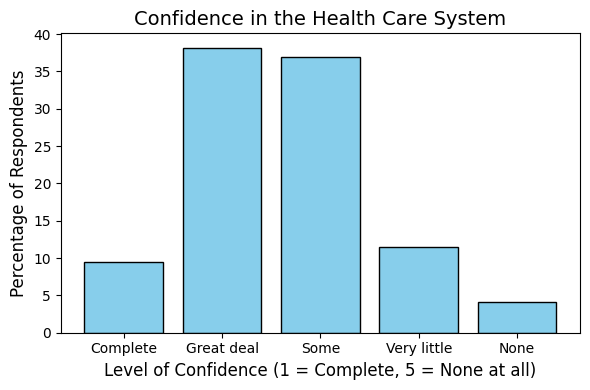

In [6]:
# Bar chart of Confidence in the Health Care System (V2):

# First we'll calculate the percentage distribution for V2 (ignoring None valid answers)
conf_counts = df['v2_num'].value_counts(normalize=True) * 100 # percentage distribution
conf_counts = conf_counts.sort_index()

labels = ['Complete','Great deal','Some','Very little','None']
positions = np.arange(len(labels))  # 0 to 4

# THis is the Plot
plt.figure(figsize=(6, 4))
plt.bar(positions, conf_counts.values, color='skyblue', edgecolor='black')
plt.title('Confidence in the Health Care System', fontsize=14)
plt.xlabel('Level of Confidence (1 = Complete, 5 = None at all)', fontsize=12)
plt.ylabel('Percentage of Respondents', fontsize=12)
plt.xticks(positions, labels)
plt.tight_layout()
plt.show()


### Interpretation:
 We can see that “Some confidence” is the most common response, followed by “A great deal of confidence.” Relatively few respondents have complete trust, and only a minority have no confidence at all in the system. This suggests most people have a moderate or cautiously positive view of their health care system, with extreme views (total trust or total distrust) being less common. The health care system seems to enjoy at least some confidence from a majority of respondents, though clearly there is room for improvement as not many are fully confident.

## 2. Frequency of Internet Use for Health Information – Distribution

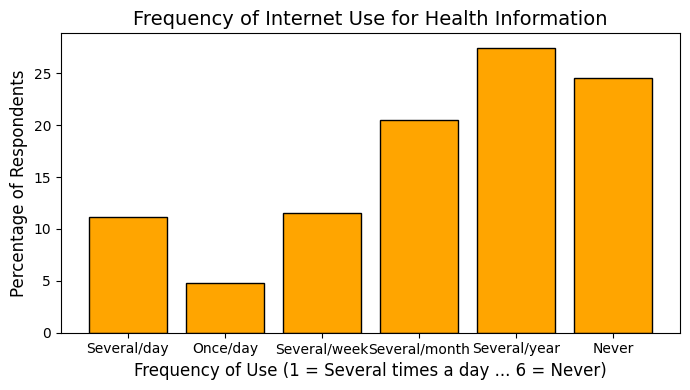

In [7]:
# Bar chart of Frequency of Internet Use for Health Information (V22):

# First we'll compute percentage distribution for V22 (internet usage frequency)
usage_counts = df['v22_num'].value_counts(normalize=True) * 100
usage_counts = usage_counts.sort_index()  # 1–6

labels = ['Several/day', 'Once/day', 'Several/week', 'Several/month', 'Several/year', 'Never']
positions = np.arange(len(labels))  # 0 to 5


plt.figure(figsize=(7, 4))
plt.bar(positions, usage_counts.values, color='orange', edgecolor='black')
plt.title('Frequency of Internet Use for Health Information', fontsize=14)
plt.xlabel('Frequency of Use (1 = Several times a day ... 6 = Never)', fontsize=12)
plt.ylabel('Percentage of Respondents', fontsize=12)
plt.xticks(positions, labels, rotation=0)
plt.tight_layout()
plt.show()


### Interpretation:
 There is a clear split in the population’s behavior:

* A significant proportion of respondents never (or almost never) go online for health information – this is evident from the tall bar at the “Never” category. This group might include those who either lack internet access, prefer traditional sources (like consulting doctors directly), or perhaps older individuals less accustomed to using the internet for health purposes.

* On the other end, we do have a smaller segment of frequent users: a noticeable bar for daily or weekly usage. These likely represent more digitally savvy individuals who regularly turn to Google, WebMD, or other online resources whenever they have health questions or needs.

* The middle categories (monthly or yearly) indicate occasional use by some people – they might look things up only when a specific need arises (e.g., a new medication or a health scare once in a while).



## 3. Internet Attitudes vs. Confidence in Healthcare – Comparative Analysis

To address our core question, we examine whether people’s trust in the health care system is related to how they view or use online health information. We’ll do two comparisons:

A) Belief that the Internet is useful to verify doctors’ advice, by confidence group: We split respondents into two groups – those with High confidence in the health care system (answered “Complete” or “A great deal of” confidence for v2) and those with Low confidence (“Very little” or “No confidence”). We then calculate what proportion of each group agrees that “the internet is useful to double-check advice from my doctor” (v29 being 1 or 2 on the agree scale).

Percent who agree Internet helps verify doctor - HIGH confidence group: 31.7%
Percent who agree Internet helps verify doctor - LOW confidence group: 37.7%


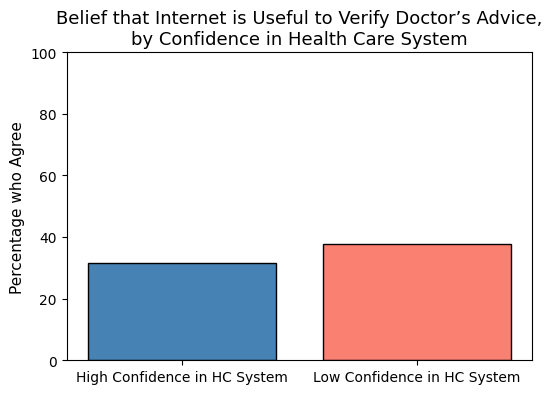

In [8]:
# Define high vs low confidence groups based on v2 (exclude middle "some confidence")
high_conf_mask = df['v2_num'].isin([1, 2])   # v2 = 1 or 2 => high confidence
low_conf_mask  = df['v2_num'].isin([4, 5])   # v2 = 4 or 5 => low confidence

high_conf_group = df[high_conf_mask]
low_conf_group  = df[low_conf_mask]

# Proportion in each group that agree (v29 == 1 or 2 means agree/strongly agree internet is useful to verify doctor)
prop_agree_high = (high_conf_group['v29_num'].isin([1, 2])).mean(skipna=True) * 100
prop_agree_low  = (low_conf_group['v29_num'].isin([1, 2])).mean(skipna=True) * 100

print(f"Percent who agree Internet helps verify doctor - HIGH confidence group: {prop_agree_high:.1f}%")
print(f"Percent who agree Internet helps verify doctor - LOW confidence group: {prop_agree_low:.1f}%")

# Bar chart comparing the two percentages
groups = ['High Confidence in HC System', 'Low Confidence in HC System']
values = [prop_agree_high, prop_agree_low]

plt.figure(figsize=(6,4))
plt.bar(groups, values, color=['steelblue','salmon'], edgecolor='black')
plt.title('Belief that Internet is Useful to Verify Doctor’s Advice,\nby Confidence in Health Care System', fontsize=13)
plt.ylabel('Percentage who Agree', fontsize=11)
plt.ylim(0, 100)
plt.show()



### Findings:
 There is a notable difference between the two groups:

* Among people with low confidence in the health care system, a higher proportion agree that the internet is useful for double-checking doctors.

* Those with high confidence in the system are less likely to see a need to verify their doctor’s advice online (a smaller percentage of this group agrees with the usefulness of internet for that purpose).

B) Frequency of Internet Use by confidence group: In addition to attitudes, let’s see actual behavior – do low-confidence individuals use the internet more often for health info than high-confidence individuals? We compare the distributions of internet usage frequency (v22) for the high vs. low confidence groups.

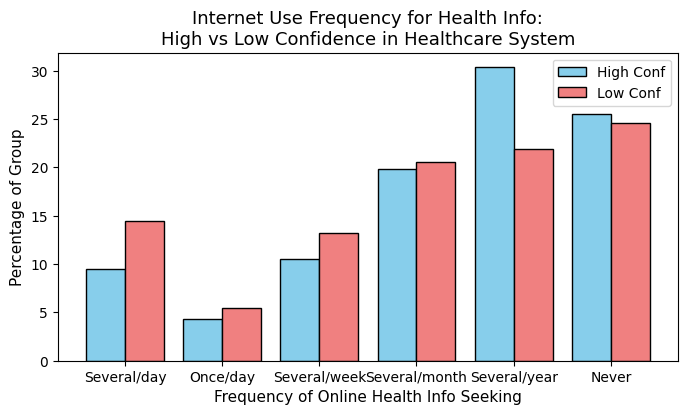

In [9]:
# Compare internet usage frequency distribution for high vs low confidence groups
usage_counts_high = high_conf_group['v22_num'].value_counts(normalize=True).sort_index() * 100
usage_counts_low  = low_conf_group['v22_num'].value_counts(normalize=True).sort_index() * 100

# Ensure all categories 1-6 are represented
freq_categories = range(1,7)
vals_high = [usage_counts_high.get(cat, 0) for cat in freq_categories]
vals_low  = [usage_counts_low.get(cat, 0) for cat in freq_categories]

# Plot side-by-side bar charts for high vs low confidence groups
labels = ['Several/day','Once/day','Several/week','Several/month','Several/year','Never']
x = np.arange(len(labels))
width = 0.4

plt.figure(figsize=(8,4))
plt.bar(x - width/2, vals_high, width, label='High Conf', color='skyblue', edgecolor='black')
plt.bar(x + width/2, vals_low,  width, label='Low Conf', color='lightcoral', edgecolor='black')
plt.title('Internet Use Frequency for Health Info:\nHigh vs Low Confidence in Healthcare System', fontsize=13)
plt.xlabel('Frequency of Online Health Info Seeking', fontsize=11)
plt.ylabel('Percentage of Group', fontsize=11)
plt.xticks(ticks=x, labels=labels, rotation=0)
plt.legend()
plt.show()


### Findings:
We observe clear differences in behavior:

* High-confidence individuals (those who trust the health system) are far more likely to never or very rarely seek health info online. Their tallest bar is at “Never”. This suggests that many in this group might rely on doctors or traditional sources for information, or simply have less inclination to double-check things on their own.

* Low-confidence individuals show a greater tendency to use the internet frequently. The low-confidence group has noticeably higher percentages in the frequent-use categories (daily/weekly). They are less represented in the “Never” category compared to the high-trust group.

## Additional Comparative Plots
which we will investigate further on our project
* Online Health Impact vs Confidence in Healthcare (V2 vs V26)
* Trust in Online Info vs Confidence in Healthcare (V2 vs V30)

# Insights & Interpretation

Bringing together the exploration above, we can summarize key insights and what they might mean:


* General Trust in Healthcare: Most respondents have moderate confidence in their country’s health care system, with relatively few at the extremes. People tend to be more satisfied with their personal healthcare experiences (doctors visits) than with the healthcare system overall. This suggests individual healthcare providers might be doing a good job even if people have criticisms of the broader system (e.g., waiting times, costs, administration).

* Prevalence of Online Health Information Seeking: There is a digital divide in health information behavior. A considerable share of people (likely older or less tech-oriented) rarely uses the internet for health info, whereas a subset of the population uses it frequently (daily/weekly). The fact that so many never use it could have implications for public health outreach – information posted online (like pandemic guidelines) might not reach those who aren’t looking for it.

* Popular Online Health Topics: Among those who do go online, the most commonly searched topics are general health and wellness (lifestyle), followed by mental health and vaccinations. The high interest in vaccination info in 2021 is notable – likely driven by COVID-19 vaccine rollout and debates. It highlights that people seek clarity and knowledge on critical and timely health issues via the internet.

* Impact of Online Information: Many people report positive outcomes from using the internet for health – such as making healthier lifestyle changes or better understanding medical instructions. This is an encouraging sign that the internet can complement healthcare by empowering patients with more understanding and motivation. However, it’s not universal; some did not experience changes, indicating that information alone doesn’t always translate to action (or they already had good habits/understanding to begin with).

* Trust in Online Info vs Doctors: There’s a nuanced view of online health information:

    * On one hand, a majority see the internet as a helpful tool for making health decisions and verifying what doctors say. This implies that even if they trust doctors, people like having a way to double-check or gather more input – essentially combining professional advice with their own research.

    * On the other hand, concerns about reliability are very common – the average person isn’t blindly trusting internet info. They are aware that not everything online is accurate, which reflects a healthy skepticism and the need for guidance in finding credible sources.

    * These mixed attitudes show that online resources are a double-edged sword: they empower and inform patients, but also can mislead or overwhelm them if they cannot discern quality information. The medical community and public health authorities might leverage the positive (by guiding people to good resources) and mitigate the negative (educating about misinformation).

* Relationship between Digital Engagement and Trust in Healthcare: Our exploratory analysis suggests a noteworthy pattern: individuals who have lower trust in the health care system or providers tend to engage more with online health information. Specifically, they are more likely to frequently search the internet about health and to trust what they find there enough to use it as a second opinion. Conversely, those who highly trust the system are less inclined to seek external information – presumably because they feel the information from their doctors is sufficient or because they are less inclined to question it.

    * This raises important questions: Does distrust drive people to Google, or does googling (and perhaps encountering conflicting information or negative stories) feed distrust? The data at least confirm these two aspects are linked. It might be a feedback loop as well.

    * There could also be third factors involved – for example, younger people might both use the internet more and have different expectations from healthcare (thus appearing less “confident” in it), whereas older folks trust doctors more and don’t use internet as much. In that case, age (or education) would be an underlying factor influencing both. We haven’t yet delved into demographic splits, but that would be a logical next step.

In summary, our initial exploration highlights a tension between traditional healthcare trust and the new paradigm of information access. People increasingly have the means to inform themselves and cross-check professionals, which can be empowering but also reflects underlying trust issues.

# Further Questions & Proposed Research Directions
Based on our initial findings, several deeper questions emerge:

- **Does demographic background (age, education, country) moderate the relationship** between internet use and healthcare trust? Are younger, more tech-savvy individuals both more skeptical and more engaged online?

- **Causality vs Correlation:** Does high internet use lead to lower trust (e.g., due to misinformation), or does low trust push people to seek alternatives online? Longitudinal data could help clarify this.

- **How does satisfaction with individual doctors (v45) interact with internet attitudes?** Is trust in doctors stronger than trust in the system or information sources?

- **What role does health status or chronic illness play?** People with frequent healthcare needs may behave differently online.

- **Cross-country variation:** Are there patterns where some countries show high trust and high digital use (or low trust and low digital literacy)?



# Internet usage intensity regarding health topics

In this section, we examine how frequently respondents use the internet for health-related information.
We create a new label, “frequency of internet use”, based on survey question v22, and categorize respondents into three groups:

High use

Medium use

Low use

We then use these groups as class labels to analyze whether respondents’ attitudes and behaviors regarding online health information (v23–v30) can predict their level of internet use.

This allows us to explore the relationship between internet usage frequency and perceived effectiveness of online health information.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

df = df.dropna()

df['internet_use_group'] = None
# High usage: 1–2 -> 2
df.loc[df['v22_num'] <= 2, 'internet_use_group'] = 2
# Medium usage: 3–4 -> 1
df.loc[(df['v22_num'] > 2) & (df['v22_num'] <= 4), 'internet_use_group'] = 1
# Low usage: 5 -> 0
df.loc[df['v22_num'] > 4, 'internet_use_group'] = 0

df['internet_use_group'] = df['internet_use_group'].astype(int)

X = df[['v23_num','v24_num','v25_num','v26_num','v27_num','v28_num','v29_num','v30_num']]
y = df['internet_use_group']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.56      0.73      0.64      2879
           1       0.46      0.38      0.41      2145
           2       0.33      0.18      0.23      1037

    accuracy                           0.51      6061
   macro avg       0.45      0.43      0.43      6061
weighted avg       0.49      0.51      0.49      6061



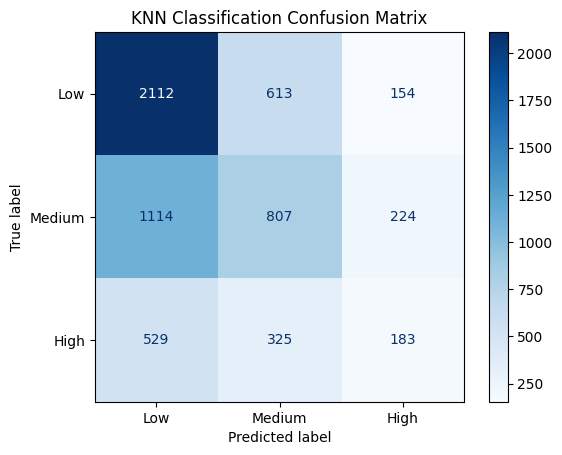

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Low', 'Medium', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("KNN Classification Confusion Matrix")
plt.show()


As we can see from the confusion matrix, the KNN model is not particularly effective for predicting internet usage frequency based on the survey questions.

For respondents labeled as “Low use”, the model predicts fairly accurately.

For “Medium use” and “High use” respondents, predictions are much less reliable.

We attribute this to a couple of factors:

The Low use group is the largest, meaning it dominates the dataset and causes the algorithm to favor this group, even when lowering the k value.

There may be overlap in survey responses between groups, which leads to misclassification of Medium and High users.

In conclusion, while the model performs slightly better than random guessing, it is not strong enough to suggest a clear connection between survey responses and internet usage intensity.

Cluster summaries (average values per feature):
          v22_num   v23_num   v24_num   v25_num   v26_num   v27_num   v28_num  \
cluster                                                                         
0        4.370138  2.148015  1.561341  2.108019  2.679134  2.489029  2.358069   
1        3.271845  3.448750  3.000086  3.290403  2.484320  2.411547  2.585274   
2        4.839296  2.074679  1.549844  2.056501  3.808267  3.847980  3.875072   

          v29_num   v30_num  
cluster                      
0        2.492220  2.415420  
1        2.707707  2.362832  
2        4.010999  2.092277  


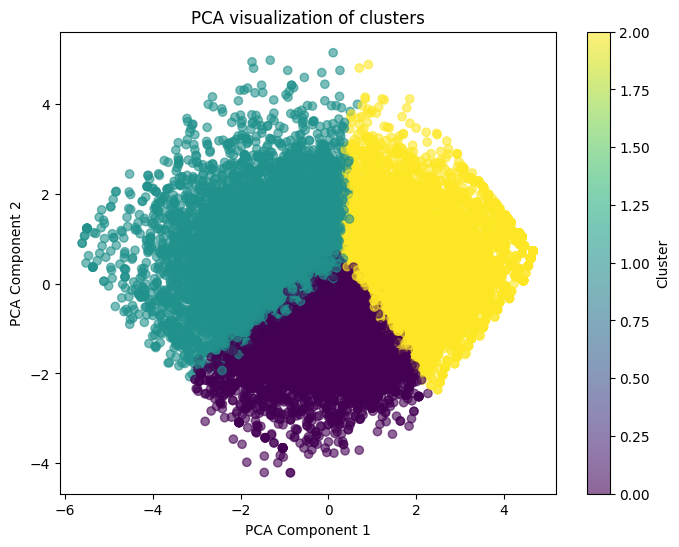

In [14]:

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

features = ['v22_num','v23_num','v24_num','v25_num','v26_num','v27_num','v28_num','v29_num','v30_num']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df['cluster'] = clusters

cluster_summary = df.groupby('cluster')[features].mean()
print("Cluster summaries (average values per feature):")
print(cluster_summary)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA visualization of clusters')
plt.colorbar(label='Cluster')
plt.show()


After trying KNN, we decided that labeling respondents upfront might not be the best approach, so we switched to an unsupervised learning method, K-Means.

We selected all features related to internet usage and behavior (v22–v30) to see if the data naturally forms clusters that could reflect different patterns of internet use. We intentionally chose K = 3 to explore whether respondents could be grouped meaningfully.

After running the K-Means algorithm, we found that the data does have a noticeable structure. Based on the average value of v22 (Frequency of internet use for health information), we can interpret the clusters as:

Cluster 1 – High Use

Cluster 0 – Medium Use

Cluster 2 – Low Use

This shows that the clustering captures patterns of internet use even without predefined labels, supporting the idea that respondents’ behavior and attitudes naturally separate them into distinct groups.

Looking at the averages of the different questions across clusters confirms this interpretation.

Questions v26–v30 were answered on a scale from 1 = Strongly agree to 5 = Strongly disagree:

v26: Information from the internet has positively affected my health behaviors

v27: Information from the internet helped me understand my doctor better

v28: Using the internet is useful for deciding how to treat an illness or whether to see a doctor

v29: The internet is useful to double-check advice from my doctor

v30: It is not easy to distinguish reliable health information on the internet

The averages align with our cluster labeling. The Low Use cluster (Cluster 2) shows higher average scores for these items, indicating less positive impact or trust in internet information.

Examining the topic-specific questions v23–v25 (seeking information on lifestyle, mental health, and vaccinations), we see that the High Use group (Cluster 1) has slightly higher averages, meaning they are less active in these specific topics than we initially expected. This suggests that frequent internet users do not necessarily search all health topics equally; they may use the internet more broadly or for other purposes.

Looking more closely at v28 and v30:

v28 is lower in the High Use group (Cluster 1), which aligns with our expectation that they actively use the internet for health decisions.

v30, which measures difficulty distinguishing reliable information, shows that the High Use group is more aware of this problem than the Medium Use group, suggesting frequent users recognize misinformation risks.

The Low Use group has the lowest average for v30, raising the question: do they avoid using the internet because they are aware of misinformation, or is it due to myths, misconceptions, or lack of confidence in online health information?

Overall, the clustering reveals distinct patterns in internet usage and highlights that high frequency does not always mean high engagement with every specific health topic, providing nuanced insight into respondents’ behavior.

<Figure size 1200x600 with 0 Axes>

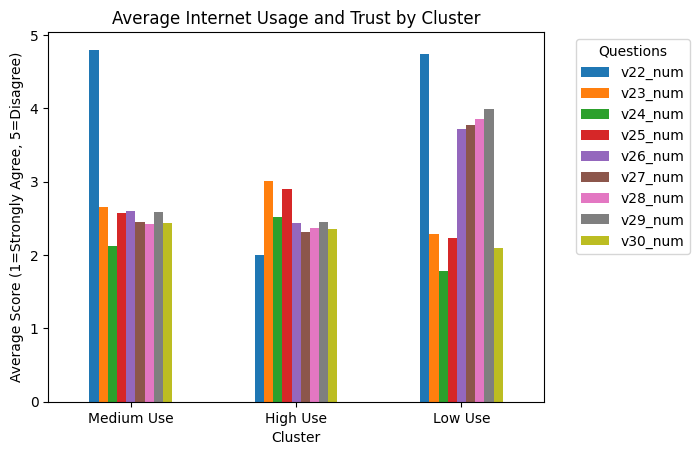

<Figure size 1000x500 with 0 Axes>

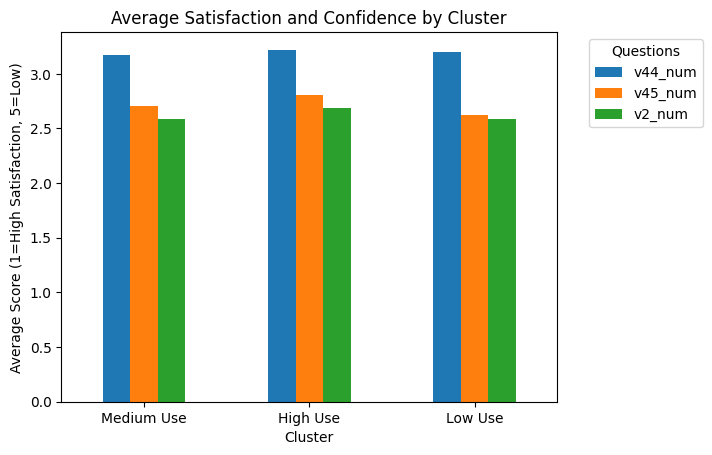

In [13]:
import matplotlib.pyplot as plt
import pandas as pd


internet_features = [
    'v22_num','v23_num','v24_num','v25_num',
    'v26_num','v27_num','v28_num','v29_num','v30_num'
]
satisfaction_features = ['v44_num','v45_num']
confidence_features = ['v2_num']


features = internet_features + satisfaction_features + confidence_features


df[features] = df[features].apply(pd.to_numeric, errors='coerce')


cluster_means = df.groupby('cluster')[features].mean()


cluster_means.index = ['Medium Use','High Use','Low Use']


plt.figure(figsize=(12,6))
cluster_means[internet_features].plot(kind='bar', rot=0)
plt.title("Average Internet Usage and Trust by Cluster")
plt.ylabel("Average Score (1=Strongly Agree, 5=Disagree)")
plt.xlabel("Cluster")
plt.legend(title="Questions", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


plt.figure(figsize=(10,5))
cluster_means[satisfaction_features + confidence_features].plot(kind='bar', rot=0)
plt.title("Average Satisfaction and Confidence by Cluster")
plt.ylabel("Average Score (1=High Satisfaction, 5=Low)")
plt.xlabel("Cluster")
plt.legend(title="Questions", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In addition to internet usage patterns, we examined respondents’ confidence in the healthcare system (v2) and satisfaction with healthcare services (v44, v45) across the clusters. The bar chart of cluster averages shows that these measures are relatively similar across Low, Medium, and High Use clusters.

For v44 (satisfaction with the healthcare system) and v45 (satisfaction with last visit to a doctor), there is no substantial difference between clusters, suggesting that frequency of internet use for health information does not strongly correlate with satisfaction.

Similarly, v2 (confidence in the healthcare system) averages remain largely consistent across clusters, indicating that confidence in healthcare is not directly influenced by internet usage intensity.

These findings imply that while K-Means clustering highlights distinct behavioral patterns in internet use and perceptions of online health information (v22–v30), it does not reveal a clear relationship with overall satisfaction or trust in the healthcare system. This supports the conclusion that high or low internet usage does not necessarily correspond to positive or negative perceptions of healthcare services.